# Multi-task correlated GP testing

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from botorch.models import MultiTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch

/Users/mc/miniforge3/envs/py3.11-sva/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
torch.set_default_dtype(torch.float64)

In [100]:
def f1(x):
    return torch.sin(x * 2.0 * np.pi)

def f2(x):
    return torch.sin(x * 2.0 * np.pi) + np.random.normal(scale=0.1, size=x.shape)

In [101]:
torch.manual_seed(125)

N1 = 2
N2 = 20

X1 = torch.rand(N1, 1)
X2 = torch.rand(N2, 1)

i1 = torch.zeros(N1, 1, dtype=int)
i2 = torch.ones(N2, 1, dtype=int)

train_X = torch.cat([
    torch.cat([X1, i1], -1), torch.cat([X2, i2], -1),
])

In [102]:
train_Y = torch.cat([f1(X1), f2(X2)])

In [103]:
model = MultiTaskGP(train_X, train_Y, task_feature=-1)

In [104]:
mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)

In [105]:
model.train()
mll.train()
fit_gpytorch_mll(mll)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): MultiTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
  )
)

In [106]:
x_test = torch.linspace(0, 1, 1000)
model.eval()
mll.eval()
posterior = model.posterior(x_test.reshape(-1, 1), observation_noise=False)
mean = posterior.mean.detach().numpy().squeeze()
var = posterior.variance.detach().numpy().squeeze()

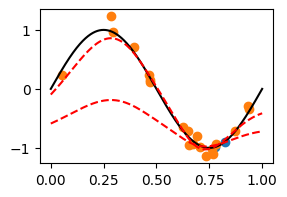

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(3, 2))

ax.plot(x_test, f1(x_test), "k-")
ax.plot(x_test, mean[:, 0], "r--")
ax.scatter(X1, f1(X1))

# ax.plot(x_test, f2(x_test), "k-")
ax.plot(x_test, mean[:, 1], "r--")
ax.scatter(X2, f2(X2))

# Compare with standard approach

In [22]:
from botorch.models import SingleTaskGP

In [23]:
model1 = SingleTaskGP(X1, f1(X1))
mll1 = ExactMarginalLogLikelihood(likelihood=model1.likelihood, model=model1)
model2 = SingleTaskGP(X2, f2(X2))
mll2 = ExactMarginalLogLikelihood(likelihood=model2.likelihood, model=model2)

In [24]:
fit_gpytorch_mll(mll1)
fit_gpytorch_mll(mll2)

ExactMarginalLogLikelihood(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (model): SingleTaskGP(
    (likelihood): GaussianLikelihood(
      (noise_covar): HomoskedasticNoise(
        (noise_prior): GammaPrior()
        (raw_noise_constraint): GreaterThan(1.000E-04)
      )
    )
    (mean_module): ConstantMean()
    (covar_module): ScaleKernel(
      (base_kernel): MaternKernel(
        (lengthscale_prior): GammaPrior()
        (raw_lengthscale_constraint): Positive()
        (distance_module): Distance()
      )
      (outputscale_prior): GammaPrior()
      (raw_outputscale_constraint): Positive()
    )
  )
)

In [25]:
x_test = torch.linspace(0, 1, 1000)
model1.eval()
mll1.eval()
model2.eval()
mll2.eval()

posterior1 = model1.posterior(x_test.reshape(-1, 1), observation_noise=False)
mean1 = posterior1.mean.detach().numpy().squeeze()
var1 = posterior1.variance.detach().numpy().squeeze()

posterior2 = model2.posterior(x_test.reshape(-1, 1), observation_noise=False)
mean2 = posterior2.mean.detach().numpy().squeeze()
var2 = posterior2.variance.detach().numpy().squeeze()

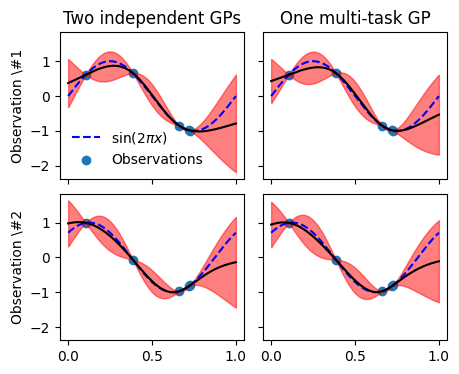

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(5, 4), sharex=True, sharey=True)

ax = axs[0, 1]
mu = mean[:, 0]
sd = np.sqrt(var[:, 0])
ax.plot(x_test, f1(x_test), "b--")
ax.scatter(X1, f1(X1))
ax.plot(x_test, mu, 'k-')
ax.fill_between(x_test, mu - 2.0*sd, mu + 2.0*sd, color="red", alpha=0.5)



ax = axs[1, 1]
mu = mean[:, 1]
sd = np.sqrt(var[:, 1])
ax.plot(x_test, f2(x_test), "b--")
ax.scatter(X2, f2(X2))
ax.plot(x_test, mu, 'k-')
ax.fill_between(x_test, mu - 2.0*sd, mu + 2.0*sd, color="red", alpha=0.5)



ax = axs[0, 0]
mu = mean1
sd = np.sqrt(var1)
ax.plot(x_test, f1(x_test), "b--", label="$\sin(2\pi x)$")
ax.scatter(X1, f1(X1), label="Observations")
ax.plot(x_test, mu, 'k-')
ax.fill_between(x_test, mu - 2.0*sd, mu + 2.0*sd, color="red", alpha=0.5)
ax.legend(frameon=False, loc="lower left")



ax = axs[1, 0]
mu = mean2
sd = np.sqrt(var2)
ax.plot(x_test, f2(x_test), "b--")
ax.scatter(X2, f2(X2))
ax.plot(x_test, mu, 'k-')
ax.fill_between(x_test, mu - 2.0*sd, mu + 2.0*sd, color="red", alpha=0.5)


axs[0, 0].set_title("Two independent GPs")
axs[0, 1].set_title("One multi-task GP")

axs[0, 0].set_ylabel("Observation \#1")
axs[1, 0].set_ylabel("Observation \#2")

plt.subplots_adjust(hspace=0.1, wspace=0.1)